# Projeto COVID-19
## Digital Innovation One

In [36]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import re
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt


In [37]:
# import data
url = 'https://raw.githubusercontent.com/fellisberto/Covid19-Previsao-ML/main/data/covid_19_data.csv'
df = pd.read_csv(url, parse_dates=['ObservationDate', 'Last Update'])
df

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


In [38]:
def rename_columns(col_name):
    return re.sub(r"[/| ]", "", col_name).lower()

In [39]:
df.columns = [rename_columns(col) for col in df.columns]
df

,sno,observationdate,provincestate,countryregion,lastupdate,confirmed,deaths,recovered
0,1,2020-01-22,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,2020-01-22,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,2020-01-22,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,2020-01-22,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,2020-01-22,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
26708,26709,2020-05-19,Wyoming,US,2020-05-20 02:32:19,776.0,10.0,0.0
26709,26710,2020-05-19,Xinjiang,Mainland China,2020-05-20 02:32:19,76.0,3.0,73.0
26710,26711,2020-05-19,Yukon,Canada,2020-05-20 02:32:19,11.0,0.0,11.0
26711,26712,2020-05-19,Yunnan,Mainland China,2020-05-20 02:32:19,185.0,2.0,183.0


# BRASIL

In [40]:
brasil = df.loc[
    (df.countryregion == 'Brazil') &
    (df.confirmed > 0)
]

# Casos Confirmados

In [41]:
px.line(brasil, 'observationdate','confirmed', title="Casos confirmados no Brasil!")

# Novos casos por dia!

In [42]:
brasil['novoscasos'] = list(map(
    lambda x: 0 if (x==0) else brasil['confirmed'].iloc[x] - brasil['confirmed'].iloc[x-1],
    np.arange(brasil.shape[0])
))

C:\Users\Suporte\AppData\Local\Temp\ipykernel_15224\1429085487.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [43]:
# Visualizando
px.line(brasil, x='observationdate', y='novoscasos', title='Novos casos por dia')

# Mortes

In [44]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=brasil.observationdate, y=brasil.deaths, name= 'Mortes',
               mode='lines+markers', line={'color' : 'red'})
)

# Layout
fig.update_layout(title='Mortes por COVID-19 no Brasil')
fig.show()

# Taxa de crescimento

In [45]:
def taxa_crescimento(data, variable, data_inicio=None, data_fim=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
        
    if data_fim == None:
        data_fim = data.observationdate.iloc[-1]
    else:
        data_fim = pd.to_datetime(data_fim)
    
    # Define os valores de presente e passado
    passado = data.loc[data.observationdate == data_inicio, variable].values[0]
    presente = data.loc[data.observationdate == data_fim, variable].values[0]
    
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Calcula a taxa
    taxa = (presente/passado)**(1/n) - 1

    return taxa*100


In [46]:
# Taxa de crescimento médio do COVID no Brasil em todo o periodo
cresc_medio = taxa_crescimento(brasil, 'confirmed')
print(f"O crescimento médio do COVID no Brasil no período avaliado foi de {cresc_medio.round(2)}%.")

O crescimento médio do COVID no Brasil no período avaliado foi de 16.27%.


In [47]:
def taxa_crescimento_diario(data, variable, data_inicio=None):
    # Se data_inicio for None, define como a primeira data disponível no dataset
    if data_inicio == None:
        data_inicio = data.observationdate.loc[data[variable] > 0].min()
    else:
        data_inicio = pd.to_datetime(data_inicio)
    data_fim = data.observationdate.max()
    # Define o número de pontos no tempo q vamos avaliar
    n = (data_fim - data_inicio).days
    
    # Taxa calculada de um dia para outro
    taxas = list(map(
        lambda x: (data[variable].iloc[x] - data[variable].iloc[x-1]) / data[variable].iloc[x-1],
        range(1, n+1)
    ))
    
    return np.array(taxas) * 100

In [48]:
tx_dia = taxa_crescimento_diario(brasil, 'confirmed')
tx_dia

array([  0.        ,   0.        , 100.        ,   0.        ,
         0.        ,   0.        , 100.        ,   0.        ,
       225.        ,   0.        ,  53.84615385,  25.        ,
        24.        ,  22.58064516,  36.84210526, 190.38461538,
         0.        ,   7.28476821,  23.45679012,  60.5       ,
        15.88785047,  66.93548387,  27.69726248,  28.75157629,
        51.4201763 ,  24.45019405,  16.78794179,  13.66266133,
        16.87548943,  14.47236181,  14.25226807,   9.01639344,
         7.58928571,  24.8525879 ,  19.57320273,  17.67115272,
        12.58080557,  14.39929329,   7.43243243,   9.26325247,
        15.40169394,  15.22017956,  11.88620903,   8.54521335,
         5.54537122,   7.06807546,   5.57858688,   7.81903542,
        12.10513815,   7.4329096 ,  10.70501233,   8.83557983,
         5.44492335,   5.4043566 ,   5.73350023,   6.21648599,
         9.35157462,   8.00823407,   9.77184834,   6.36504619,
         6.88748019,   8.58316283,   8.80726429,   9.41

In [49]:
primeiro_dia = brasil.observationdate.loc[brasil.confirmed > 0].min()

px.line(x=pd.date_range(primeiro_dia, brasil.observationdate.max())[1:],
    y=tx_dia, title='Taxa de crescimento de casos confirmados no brasil')

# Predições

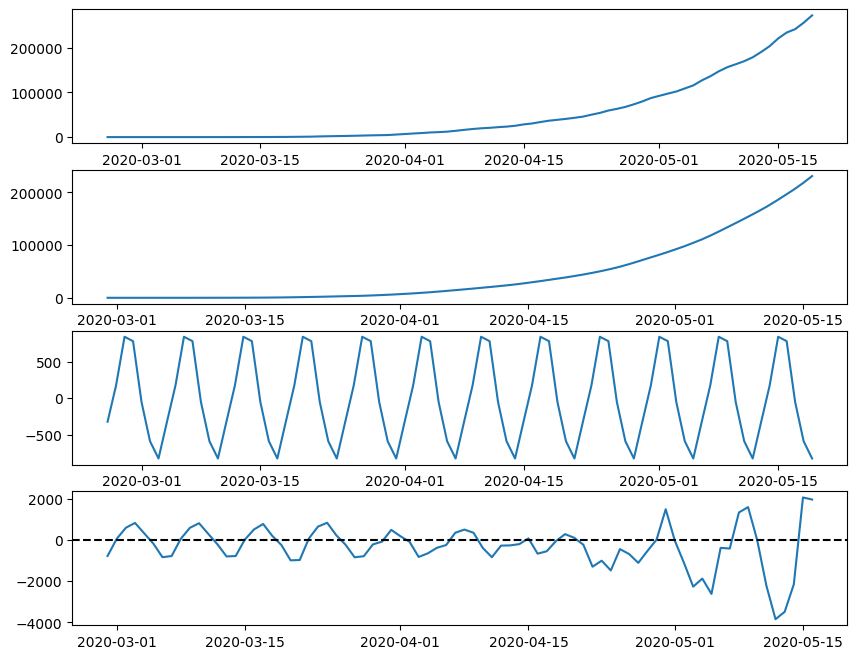

In [50]:
confirmados = brasil.confirmed
confirmados.index = brasil.observationdate

res = seasonal_decompose(confirmados)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10,8))

ax1.plot(res.observed)
ax2.plot(res.trend)
ax3.plot(res.seasonal)
ax4.plot(confirmados.index, res.resid)
ax4.axhline(0, linestyle='dashed', c="black")
plt.show()

# ARIMA

In [51]:
!pip install pmdarima


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: C:\Users\Suporte\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [52]:
from pmdarima.arima import auto_arima
modelo = auto_arima(confirmados)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject